# crms_representation_cell_type_specific

02/06/2020

test cell-type specific prediction

todo
- test model performance with only certan parameters
- edit the model type
- set up sequence information

# 0. startup


In [1]:
import os, glob
import pandas as pd
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import itertools
from scipy.stats.stats import pearsonr

from collections import Counter, defaultdict
import time
from sklearn.preprocessing import OneHotEncoder

In [2]:
# loading files

In [3]:
hoco_annon_file = 'annon/HOCOMOCOv11_core_annotation_HUMAN_mono.tsv'
hoco_annon = pd.read_table(hoco_annon_file,header=0)
hoco_annon[['motif_abbr','motif_info']]=hoco_annon['Model'].str.split("_",expand=True)
hoco_motif_to_tf = pd.Series(hoco_annon['Transcription factor'].values, index=hoco_annon.motif_abbr.values).to_dict()
tfs = list(hoco_annon['Transcription factor'])

In [4]:
THRES=1
rna_tpm_file = 'rnaseq/tissue_tpm_sym.csv'
rna_df = pd.read_csv(rna_tpm_file, index_col=0,header=0)
rna_df.index = [x.upper() for x in rna_df.index.values]
all_genes = rna_df.index
tissue_diffloop_to_rna = {
    'Air':'Airway', 'Astro':'Astrocytes', 'Blad':'Bladder', 'Colon':'Colon', 'Eso':'Esophageal', 
    'GDSD0':'GDSD0', 'GDSD3':'GDSD3', 'GDSD6':'GDSD6', 
    'GM12878':'GM12878', 'HMEC':'HMEC', 'MC':'Melanocytes', 'Ova':'Ovarian',
    'Panc':'Pancreas', 'Pros':'Prostate', 'Renal':'Renal', 'Thy':'Thyroid', 'Uter':'Uterine'
}

def get_exp(rna_df, sym, tissue,verbose=True):
    try:
        return rna_df.loc[sym,tissue]
    except KeyError:
        if verbose:
            print(sym, 'not found')
        return 0

In [5]:
loop_files = sorted(glob.glob('diffloop_data/bedpe_files_csvs_rna/*merged.loops.csv'))
anchor_files = sorted(glob.glob('diffloop_data/bedpe_files_csvs_rna/*merged.anchors.csv'))
print(loop_files)
print(anchor_files)

['diffloop_data/bedpe_files_csvs_rna/Air-5000-separate-merged.loops.csv', 'diffloop_data/bedpe_files_csvs_rna/Astro-5000-separate-merged.loops.csv', 'diffloop_data/bedpe_files_csvs_rna/Blad-5000-separate-merged.loops.csv', 'diffloop_data/bedpe_files_csvs_rna/Colon-5000-separate-merged.loops.csv', 'diffloop_data/bedpe_files_csvs_rna/Eso-5000-separate-merged.loops.csv', 'diffloop_data/bedpe_files_csvs_rna/GDSD0-5000-separate-merged.loops.csv', 'diffloop_data/bedpe_files_csvs_rna/GDSD3-5000-separate-merged.loops.csv', 'diffloop_data/bedpe_files_csvs_rna/GDSD6-5000-separate-merged.loops.csv', 'diffloop_data/bedpe_files_csvs_rna/GM12878-5000-separate-merged.loops.csv', 'diffloop_data/bedpe_files_csvs_rna/HMEC-5000-separate-merged.loops.csv', 'diffloop_data/bedpe_files_csvs_rna/MC-5000-separate-merged.loops.csv', 'diffloop_data/bedpe_files_csvs_rna/Ova-5000-separate-merged.loops.csv', 'diffloop_data/bedpe_files_csvs_rna/Panc-5000-separate-merged.loops.csv', 'diffloop_data/bedpe_files_csvs_rn

In [6]:
crm_files = sorted(glob.glob('networks/diffgene/all_no_thres/*_crm_tissue.csv'))
crm_files

['networks/diffgene/all_no_thres/all_Air_crm_tissue.csv',
 'networks/diffgene/all_no_thres/all_Astro_crm_tissue.csv',
 'networks/diffgene/all_no_thres/all_Blad_crm_tissue.csv',
 'networks/diffgene/all_no_thres/all_Colon_crm_tissue.csv',
 'networks/diffgene/all_no_thres/all_Eso_crm_tissue.csv',
 'networks/diffgene/all_no_thres/all_GDSD0_crm_tissue.csv',
 'networks/diffgene/all_no_thres/all_GDSD3_crm_tissue.csv',
 'networks/diffgene/all_no_thres/all_GDSD6_crm_tissue.csv',
 'networks/diffgene/all_no_thres/all_GM12878_crm_tissue.csv',
 'networks/diffgene/all_no_thres/all_HMEC_crm_tissue.csv',
 'networks/diffgene/all_no_thres/all_MC_crm_tissue.csv',
 'networks/diffgene/all_no_thres/all_Ova_crm_tissue.csv',
 'networks/diffgene/all_no_thres/all_Panc_crm_tissue.csv',
 'networks/diffgene/all_no_thres/all_Pros_crm_tissue.csv',
 'networks/diffgene/all_no_thres/all_Renal_crm_tissue.csv',
 'networks/diffgene/all_no_thres/all_Thy_crm_tissue.csv',
 'networks/diffgene/all_no_thres/all_Uter_crm_tissue.

In [7]:
tissues = []
for crm in crm_files:
    tissues.append(os.path.basename(crm).split('_')[1])
tissue_dict = dict(zip(tissues,range(len(tissues))))
tissue_dict

{'Air': 0,
 'Astro': 1,
 'Blad': 2,
 'Colon': 3,
 'Eso': 4,
 'GDSD0': 5,
 'GDSD3': 6,
 'GDSD6': 7,
 'GM12878': 8,
 'HMEC': 9,
 'MC': 10,
 'Ova': 11,
 'Panc': 12,
 'Pros': 13,
 'Renal': 14,
 'Thy': 15,
 'Uter': 16}

# 1. create representation of crms (numerical format)
- one hot encoding for each of downstream machine learning
- save in `networks/representations`
- see `crms_representation.ipynb`

2. activity by contact
what is the correlation between expression of a gene and 
- the number of unique loops it contains
- sum of read counts aggregated over all loops
- number of atac regions



In [8]:
# data_all['log_exp'] = np.log(np.array(labels_all)+1e-2)

In [9]:
# g = sns.jointplot("num_loop_counts", "log_exp", data=data_all, kind="reg")#,
# #                   xlim=(0, 60), ylim=(0, 12), color="m", height=7)
# print(data_all['log_exp'].corr(data_all['num_loop_counts']))
# plt.savefig(os.path.join(save_dir,'logexp_v_num_loop_counts.png'))

In [10]:
# g2 = sns.jointplot("num_loops", "log_exp", data=data_all, kind="reg")#,
# #                   xlim=(0, 60), ylim=(0, 12), color="m", height=7)
# print(data_all['log_exp'].corr(data_all['num_loops']))
# plt.savefig(os.path.join(save_dir,'logexp_v_num_loops.png'))

In [11]:
# g3 = sns.jointplot("num_snp", "log_exp", data=data_all, kind="reg")#,
# #                   xlim=(0, 60), ylim=(0, 12), color="m", height=7)
# print(data_all['log_exp'].corr(data_all['num_snp']))
# plt.savefig(os.path.join(save_dir,'logexp_v_num_snp.png'))

In [12]:
# g4 = sns.jointplot("num_atac_regions", "log_exp", data=data_all, kind="reg")#,
# #                   xlim=(0, 60), ylim=(0, 12), color="m", height=7)
# print(data_all['log_exp'].corr(data_all['num_atac_regions']))
# plt.savefig(os.path.join(save_dir,'logexp_v_num_atac_regions.png'))

In [13]:
# %%time
# sns.pairplot(data_all[["num_loops", "num_loop_counts", "num_snp", "num_atac_regions"]], diag_kind="kde")#,kind="reg")
# plt.savefig(os.path.join(save_dir,'pairplot_main_count_feats.png'))

# 2. Machine learning expression



In [14]:
import matplotlib
from sklearn.preprocessing import MinMaxScaler #StandardScaler 
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, Lasso, LassoCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn import preprocessing, metrics
from scipy import interp
from sklearn.metrics import roc_auc_score, auc, roc_curve, plot_roc_curve, confusion_matrix, accuracy_score
from collections import Counter
from sklearn.model_selection import StratifiedKFold


# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

## Data preprocessing and importing

In [15]:
data_all = pd.read_csv('networks/representations_no_tfs/data_all.csv',index_col=0,header=0)

In [16]:
labels_all = np.array(pd.read_csv('networks/representations_no_tfs/labels_all.csv',index_col=0,header=None))

In [17]:
genes_all = np.array(pd.read_csv('networks/representations_no_tfs/genes_all.csv',index_col=0,header=None))

In [18]:
data_all.shape, labels_all.shape,genes_all.shape


((291006, 824), (291006, 1), (291006, 1))

preprocess genes by converting into number

In [19]:
labels_all_bin = [1 if x > THRES else 0 for x in labels_all]

In [20]:
gene_to_num_dict = dict(zip(np.unique(genes_all),range(len(np.unique(genes_all)))))

In [21]:
genes_num_all = np.vectorize(gene_to_num_dict.get)(genes_all)

In [49]:
pd.DataFrame(np.unique(genes_all)).to_csv('networks/representations_no_tfs/genes_tested.txt',index=False,header=False)

 preprocess tissues

In [22]:
# tissue_index_dict = {}
# for tissue in tissue_dict.keys():
#     tissue_index_dict[tissue] = np.where(data_all.loc[:,tissue]==1)[0]
tissue_to_num_dict = dict(zip(tissue_dict.keys(), range(len(tissue_dict.keys()))))
tissue_df = data_all[tissue_dict.keys()].reset_index().melt('index')
tissue_df.columns = ['index','tissue','value']
tissue_df = tissue_df[tissue_df.value==1].reset_index(drop=True)
tissue_df['tissue_num'] = tissue_df.tissue.map(tissue_to_num_dict)
tissue_df[:5]

,index,tissue,value,tissue_num
0,0,Air,1.0,0
1,1,Air,1.0,0
2,2,Air,1.0,0
3,3,Air,1.0,0
4,4,Air,1.0,0


In [23]:
tissue_labels = np.array(tissue_df.tissue)
tissue_num_labels = np.array(tissue_df.tissue_num)

In [24]:
Counter(tissue_labels)

Counter({'Air': 17118,
         'Astro': 17118,
         'Blad': 17118,
         'Colon': 17118,
         'Eso': 17118,
         'GDSD0': 17118,
         'GDSD3': 17118,
         'GDSD6': 17118,
         'GM12878': 17118,
         'HMEC': 17118,
         'MC': 17118,
         'Ova': 17118,
         'Panc': 17118,
         'Pros': 17118,
         'Renal': 17118,
         'Thy': 17118,
         'Uter': 17118})

In [25]:
data_all_no_tissue = data_all.copy()

for tissue in tissue_dict.keys():
    data_all_no_tissue.drop(tissue,axis=1,inplace=True)


In [26]:
# preprocessing, remove zero variance columns, and scale rest of columns 
# remove tissue info
# if 'log_exp' in data_all_no_tissue.columns:
#     data_all_no_tissue.drop('log_exp',axis=1,inplace=True)

# keep gene expression value
# maybe add in gene?
data_all_no_tissue['log_exp'] = labels_all
data_all_no_tissue['gene_num'] = genes_num_all
    
if '_loop' in data_all_no_tissue.columns:
    data_all_no_tissue.drop('_loop',axis=1,inplace=True)

    
selector = VarianceThreshold()
data_all_varfilt = selector.fit_transform(data_all_no_tissue)
data_all_varfilt_cols = data_all_no_tissue.columns[selector.get_support()]
print(data_all_no_tissue.shape, data_all_varfilt.shape, len(data_all_varfilt_cols))
scaler = MinMaxScaler()
data_all_norm = scaler.fit_transform(data_all_varfilt)
print(data_all_varfilt.shape, data_all_norm.shape)


(291006, 808) (291006, 654) 654
(291006, 654) (291006, 654)


In [27]:
'log_exp' in data_all_varfilt_cols

True

In [28]:
save_dir = 'networks/representations_no_tfs'

## 2A: Classification:
Random Forest, SVM, etc
### 2A.0: Random Forest basic testing:


In [29]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(data_all_norm, tissue_labels,
                                                                            test_size = 0.25, random_state = 42)


print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)
# # Imputation of missing values
# train_features = train_features.fillna(train_features.mean())
# test_features = test_features.fillna(test_features.mean())


Training Features Shape: (218254, 654)
Training Labels Shape: (218254,)
Testing Features Shape: (72752, 654)
Testing Labels Shape: (72752,)


In [30]:
Counter(train_labels)

Counter({'Eso': 12835,
         'Thy': 12830,
         'HMEC': 12840,
         'Blad': 12857,
         'Colon': 12860,
         'GDSD3': 12882,
         'Air': 12835,
         'Renal': 12737,
         'Pros': 12908,
         'Astro': 12839,
         'GDSD6': 12861,
         'Ova': 12789,
         'GDSD0': 12813,
         'Panc': 12881,
         'Uter': 12839,
         'GM12878': 12795,
         'MC': 12853})

In [31]:
%%time
# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 0)
# Fit on training data
model.fit(train_features, train_labels)
# Actual class predictions
rf_predictions = model.predict(test_features)


CPU times: user 21min 18s, sys: 18.6 s, total: 21min 37s
Wall time: 1min 51s


In [42]:
# # fpr, tpr, thresholds = metrics.roc_curve(test_labels, rf_probs, pos_label=1)
# # fig, ax = plt.subplots()
# # ax.plot(fpr,tpr)
# plot_roc_curve(model, test_features, test_labels, multi_class='ovr') 

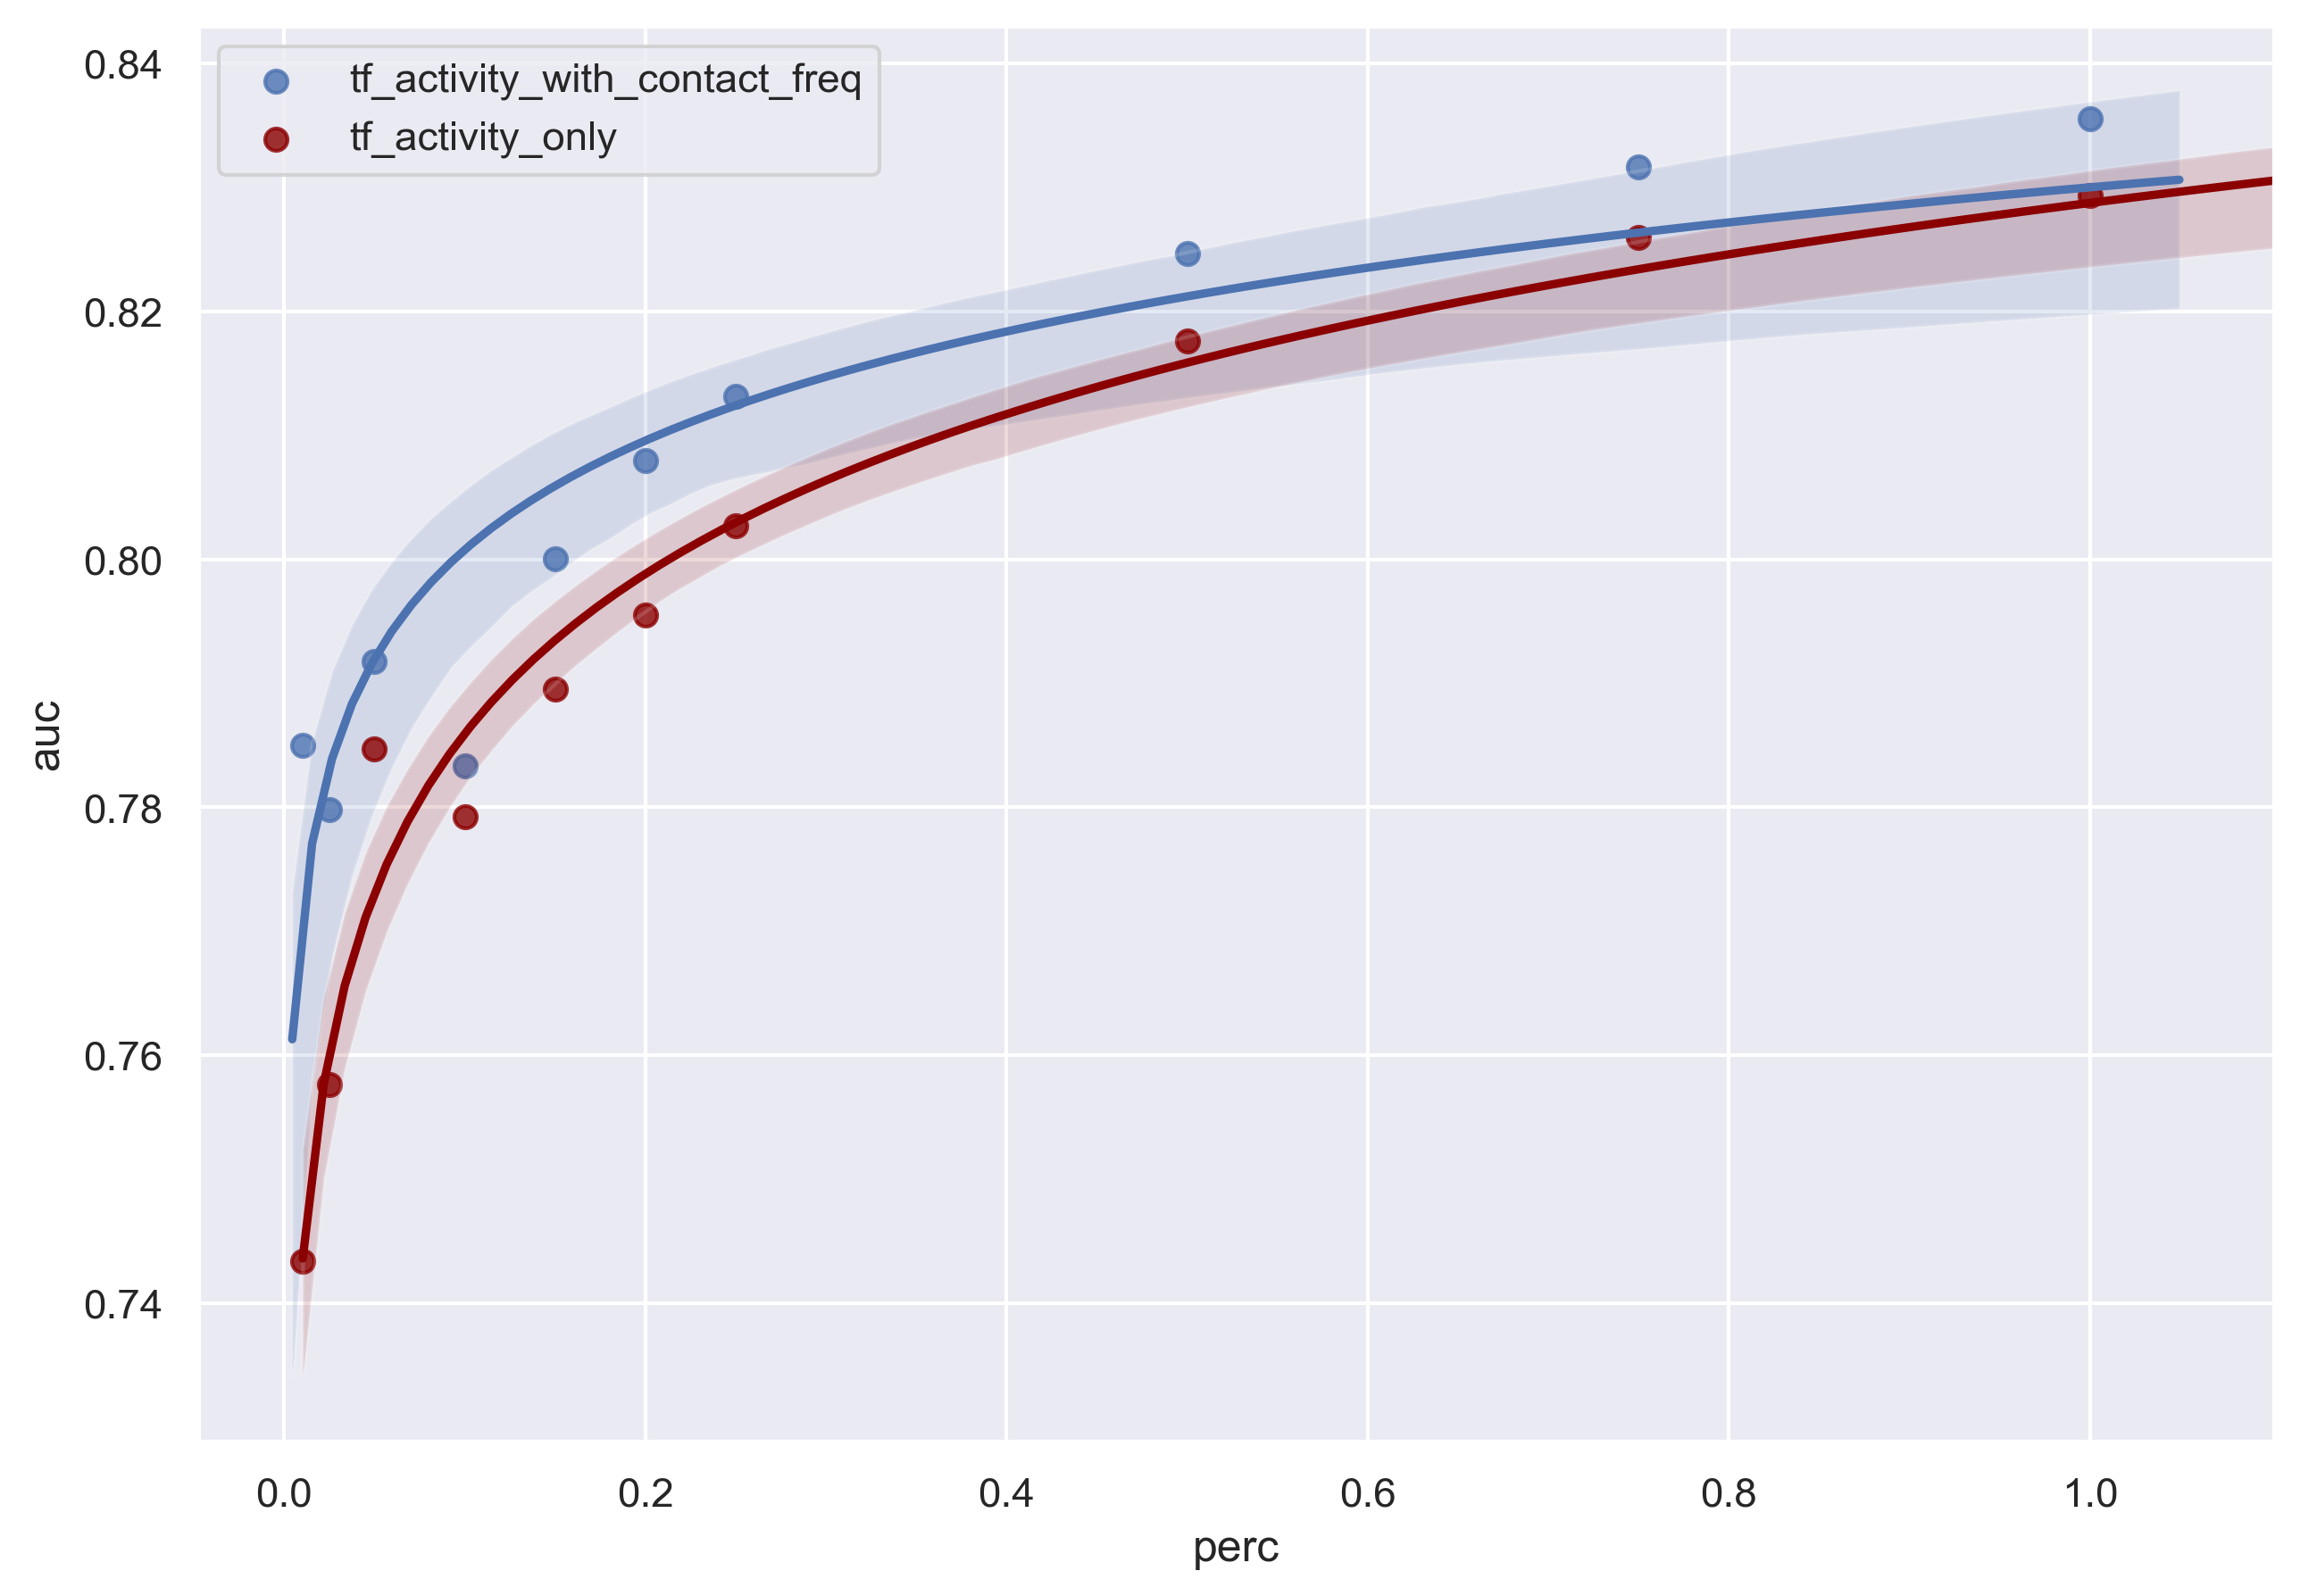

In [24]:
# # sns.lineplot(x="perc", y="roc", data= pd.DataFrame.from_dict({'perc':perc_arr, 'roc':roc_arr}, orient='columns'))

# eval_df = pd.read_csv(os.path.join('networks/representations_irf/', 'rf_perc_data_evaluation.csv'))
# fig = plt.figure(figsize=(10,7),dpi=300)
# ax = plt.subplot(111)
# sns.regplot(x="perc", y="auc",data=eval_df[eval_df.version=='tf_activity_with_contact_freq'],
#            logx=True,ax=ax,label='tf_activity_with_contact_freq')
# sns.regplot(x="perc", y="auc",data=eval_df[eval_df.version=='tf_activity_only'],
#            logx=True,ax=ax,color='darkred',label='tf_activity_only')
# ax.legend()

In [32]:
# Extract feature importances
fi = pd.DataFrame({'feature': list(data_all_varfilt_cols),
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi.head(10)

,feature,importance
652,log_exp,0.090335
653,gene_num,0.076622
649,num_loop_counts,0.029765
437,SP2_loop,0.025975
525,WT1_loop,0.023548
441,SP4_loop,0.021738
615,ZNF467_loop,0.019163
215,KLF15_loop,0.018005
111,FLI1_loop,0.015349
213,KLF12_loop,0.014737


In [33]:
# evaluation
acc = accuracy_score(test_labels, rf_predictions)
print(acc)
# Probabilities for each class
rf_probs = model.predict_proba(test_features)
# # Calculate roc auc
roc_value = roc_auc_score(test_labels, rf_probs, multi_class='ovo')
print(roc_value)

0.5100890697162964
0.8529153310819985


In [35]:
tissue_to_num_dict

{'Air': 0,
 'Astro': 1,
 'Blad': 2,
 'Colon': 3,
 'Eso': 4,
 'GDSD0': 5,
 'GDSD3': 6,
 'GDSD6': 7,
 'GM12878': 8,
 'HMEC': 9,
 'MC': 10,
 'Ova': 11,
 'Panc': 12,
 'Pros': 13,
 'Renal': 14,
 'Thy': 15,
 'Uter': 16}

In [36]:
test_labels_num = np.vectorize(tissue_to_num_dict.get)(test_labels)

test_labels_bin = (test_labels_num[:,None] == np.arange(test_labels_num.max()+1)).astype(int)
# print(test_labels_bin.shape, list(test_labels_bin[5,:]), test_labels[5])

In [37]:

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:,i], rf_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(model.classes_[i], roc_auc[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels_bin.ravel(), rf_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


Air 0.839119473900067
Astro 0.8652412918707513
Blad 0.8529434920008659
Colon 0.8700131914747538
Eso 0.8567036565017176
GDSD0 0.8346730933691042
GDSD3 0.804582067319415
GDSD6 0.8679164934099517
GM12878 0.8948353620413555
HMEC 0.7858890909245584
MC 0.8475500069660066
Ova 0.8715454264538637
Panc 0.8206985213869242
Pros 0.8868323103174217
Renal 0.8347423890036205
Thy 0.8629071598637306
Uter 0.9035767956492043


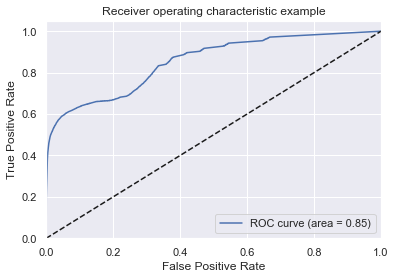

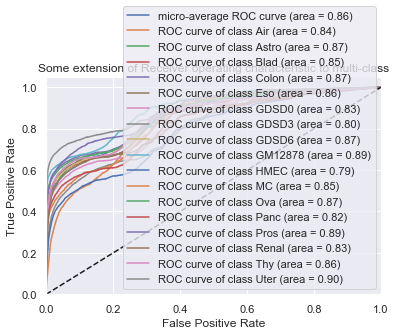

In [38]:
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]))
for i in range(len(model.classes_)):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(model.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [39]:
conf_mat = confusion_matrix(test_labels, rf_predictions)
df_confmat = pd.DataFrame(conf_mat, index = model.classes_,
                  columns = model.classes_)
display(df_confmat)

,Air,Astro,Blad,Colon,Eso,GDSD0,GDSD3,GDSD6,GM12878,HMEC,MC,Ova,Panc,Pros,Renal,Thy,Uter
Air,2248,128,176,57,64,123,193,159,112,259,236,38,211,81,56,55,87
Astro,636,2165,70,51,31,87,100,83,109,112,334,85,65,218,57,33,43
Blad,773,66,2319,27,30,114,113,82,46,124,83,49,78,126,45,17,169
Colon,633,74,37,2382,99,38,47,42,64,53,84,71,84,48,155,288,59
Eso,723,61,68,77,2176,48,76,37,52,88,59,112,138,57,399,46,66
GDSD0,726,100,210,30,37,2187,158,113,43,131,128,64,76,141,51,25,85
GDSD3,747,116,128,37,34,245,1749,158,55,383,133,45,102,144,51,32,77
GDSD6,822,86,76,34,33,149,173,2222,71,140,127,48,75,109,40,23,29
GM12878,746,120,69,33,42,66,89,84,2531,71,142,50,68,96,46,24,46
HMEC,936,105,165,36,39,215,416,125,62,1600,131,50,121,103,74,32,68


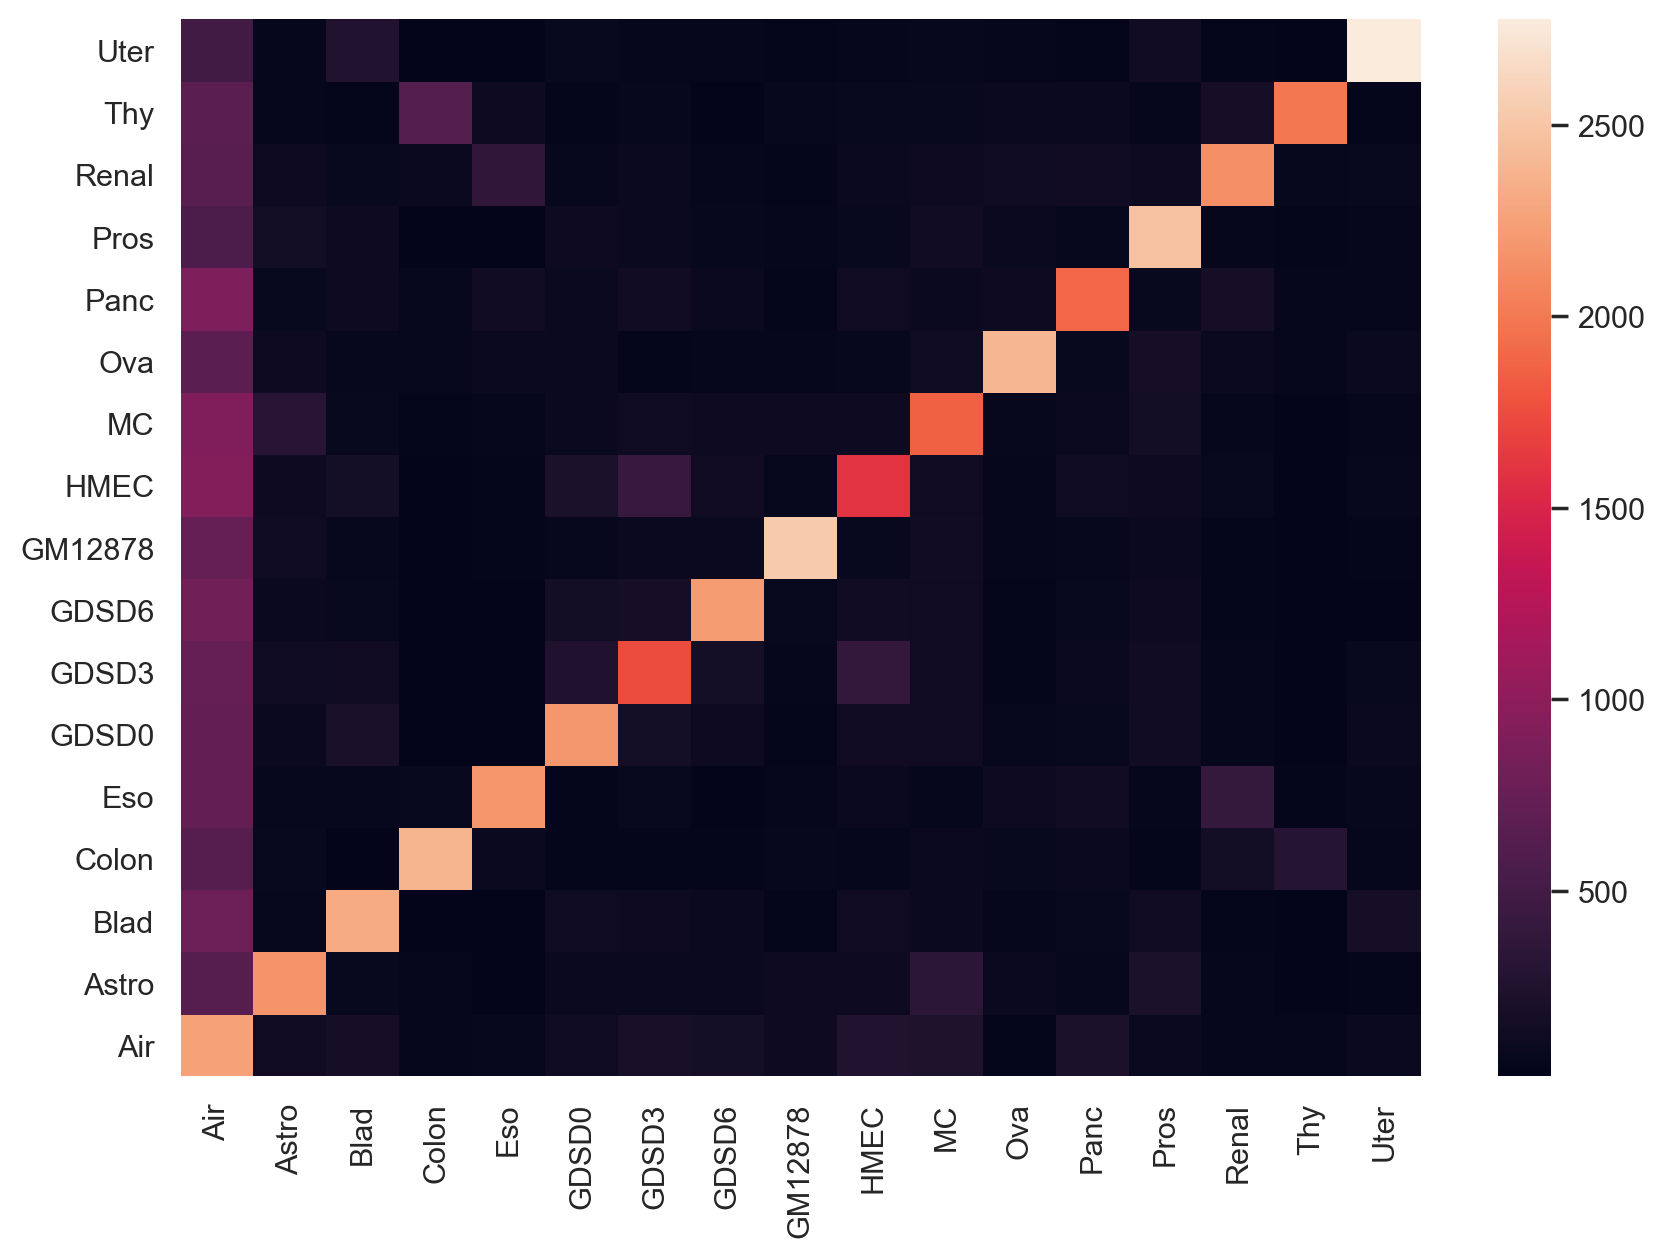

In [43]:
# fig = plt.figure()
fig,ax = plt.subplots(figsize=(10,7),dpi=200)

ax = sns.heatmap(df_confmat, annot=False)
ax.set_ylim(0,len(df_confmat))#-0.5, -0.5)
plt.savefig(os.path.join(save_dir, 'df_confmat.pdf'),pad_inches=0.4)

### 2A.1 - testing by gene split

In [78]:
# kf = KFold(n_splits=5)

In [81]:
# gene_groups  = np.zeros(len(genes_all))
# idx=1
# for train_index, test_index in kf.split(np.unique(genes_all)):
#     train_genes = np.unique(genes_all)[train_index]
#     test_genes = np.unique(genes_all)[test_index]
#     gene_groups[np.isin(genes_all,test_genes )] = idx
#     idx+=1
# Counter(gene_groups)

In [37]:
# clf = RandomForestClassifier(n_estimators=50, 
#                                max_features = 'sqrt',
#                                n_jobs=-1, verbose = 0)


In [82]:
# %%time
# cv_results = cross_validate(clf, data_all_norm, labels_all_bin, groups = gene_groups, 
#                scoring=['accuracy', 'f1', 'roc_auc','precision', 'recall'])

In [119]:
# for key, list_res in cv_results.items():
#     print(key, "%.2f +/- %.2f" % (list_res.mean(), list_res.std()))

In [ ]:
# scores = cross_val_score(clf, data_all_norm, labels_all_bin, scoring='accuracy', cv=5)
# print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'Random Forest per gene'))


### 2A.2 - test different models

In [120]:
# %%time
# clf1 = LogisticRegression(random_state=1)
# clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
# clf3 = GaussianNB()
# eclf = VotingClassifier(
#     estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)],
#     voting='hard')

# for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'Ensemble']):
#     scores = cross_val_score(clf, data_all_norm, labels_all_bin, scoring='accuracy', cv=5)
#     print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))


Results (takes about 30 min)
- Accuracy: 0.70 (+/- 0.02) [Logistic Regression]
- Accuracy: 0.77 (+/- 0.01) [Random Forest]
- Accuracy: 0.64 (+/- 0.02) [naive Bayes]
- Accuracy: 0.72 (+/- 0.02) [Ensemble]

In [47]:
clf4 = LinearSVC(random_state=0, tol=1e-5)
scores = cross_val_score(clf4, data_all_norm, labels_all_bin, scoring='roc_auc', cv=5)
print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'LinearSVC'))

Accuracy: 0.70 (+/- 0.02) [LinearSVC]


In [54]:
# doesn't work
# clf5 = LassoCV() or # Lasso()
# scores = cross_val_score(clf5, data_all_norm, labels_all_bin, scoring='roc_auc', cv=5)
# print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'Lasso'))

In [ ]:
# knn too slow
# clf6 = KNeighborsClassifier(n_neighbors=5)
# scores = cross_val_score(clf6, data_all_norm, labels_all_bin, scoring='roc_auc', cv=5)
# print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'KNN'))

In [121]:
# %%time
# clf7 = AdaBoostClassifier(n_estimators=100, random_state=0)
# scores = cross_val_score(clf7, data_all_norm, labels_all_bin, scoring='roc_auc', cv=5)
# print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'AdaBoost'))
# # >>> clf.fit(X, y)
# # AdaBoostClassifier(n_estimators=100, random_state=0)
# # >>> clf.feature_importances_
# # array([0.28..., 0.42..., 0.14..., 0.16...])
# # >>> clf.predict([[0, 0, 0, 0]])
# # array([1])
# # >>> clf.score(X, y)

In [122]:
# %%time
# clf1 = LogisticRegression(random_state=1)
# clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
# clf4 = LinearSVC(random_state=0, tol=1e-5)
# eclf = VotingClassifier(
#     estimators=[('lr', clf1), ('rf', clf2), ('svc', clf4)],
#     voting='hard')

# for clf, label in zip([eclf], ['Ensemble2']):
#     scores = cross_val_score(clf, data_all_norm, labels_all_bin, scoring='roc_auc', cv=5)
#     print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))


Accuracy: 0.70 (+/- 0.02) [Ensemble2]


###  Neural network classifers (skllearn and other)

In [123]:
# %%time
# clf8 = MLPClassifier()
# scores = cross_val_score(clf8, data_all_norm, labels_all_bin, scoring='roc_auc', cv=5)
# print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), 'MLP NN'))


Accuracy: 0.71 (+/- 0.08) [MLP NN]


In [124]:
# # TensorFlow and tf.keras
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# import tensorflow_docs as tfdocs
# import tensorflow_docs.plots
# import tensorflow_docs.modeling

# # Helper libraries
# import numpy as np
# import matplotlib.pyplot as plt

# print(tf.__version__)

In [127]:
# # Split the data into training and testing sets
# train_features, test_features, train_labels, test_labels = train_test_split(data_all_norm, tissue_num_labels,
#                                                                             test_size = 0.25, random_state = 42)


# print('Training Features Shape:', train_features.shape)
# print('Training Labels Shape:', train_labels.shape)
# print('Testing Features Shape:', test_features.shape)
# print('Testing Labels Shape:', test_labels.shape)
# # # Imputation of missing values
# # train_features = train_features.fillna(train_features.mean())
# # test_features = test_features.fillna(test_features.mean())


In [128]:
# model = keras.Sequential([
# #     keras.layers.Flatten(input_shape=(train_features.shape[1],)),
#     keras.layers.Dense(64, activation='relu', input_shape=[train_features.shape[1]]),
#     keras.layers.Dense(12, activation='relu'),
#     keras.layers.Dense(1, activation='softmax')
# ])
# model.compile(optimizer='adam',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])
# model.summary()


In [129]:
# model.fit(train_features, train_labels, epochs=10)


In [130]:
# model = build_model()
# model.summary()


In [131]:
# %%time
# EPOCHS = 100#0
# # The patience parameter is the amount of epochs to check for improvement
# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


# history = model.fit(
#   train_features, train_labels,
#   epochs=EPOCHS, validation_split = 0.2, verbose=0,
#   callbacks=[tfdocs.modeling.EpochDots()])

# # history = model.fit(train_features, train_labels, 
# #             epochs=EPOCHS, validation_split = 0.2, verbose=0, 
# #             callbacks=[early_stop, tfdocs.modeling.EpochDots()])



# model = build_model()





In [132]:
# hist = pd.DataFrame(history.history)
# hist['epoch'] = history.epoch
# hist.tail()

In [133]:
# plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
# plotter.plot({'Basic': history}, metric = "mae")
# # plt.ylim([0, 10])
# plt.ylabel('MAE ')

In [134]:
# plotter.plot({'Basic': history}, metric = "mse")
# plt.ylim([0, 20])
# plt.ylabel('MSE')

### 2A - only atac or only hichip

In [138]:
data_all_varfilt_cols

Index(['AHR_anc', 'AHR_loop', 'ALX1_anc', 'ALX1_loop', 'ARID5B_anc',
       'ARID5B_loop', 'ARNTL_anc', 'ARNTL_loop', 'ARNT_anc', 'ARNT_loop',
       ...
       'ZNF85_anc', 'ZNF85_loop', 'ZSCAN31_anc', 'ZSCAN31_loop',
       'num_atac_regions', 'num_loop_counts', 'num_loops', 'num_snp',
       'log_exp', 'gene_num'],
      dtype='object', length=654)

In [30]:
foot_prox_cols = data_all_varfilt_cols[data_all_varfilt_cols.str.contains('anc')]
foot_prox_col_idx = list(np.where(foot_prox_cols)[0])
len(foot_prox_col_idx)

324

In [36]:
foot_dist_cols = list(data_all_varfilt_cols[data_all_varfilt_cols.str.contains('loop')])
foot_dist_cols.remove('num_loop_counts')
foot_dist_cols.remove('num_loops')
foot_dist_col_idx = list(np.where(foot_dist_cols)[0])
len(foot_dist_col_idx)

324

In [44]:
foot_all_col_idx = foot_prox_col_idx + foot_dist_col_idx

In [49]:
atac_only_cols = ['num_atac_regions']
atac_only_col_idx = list(np.where([x in atac_only_cols for x in data_all_varfilt_cols ])[0])


In [50]:
hichip_only_cols = ['num_loop_counts', 'num_loops']
hichip_only_col_idx = list(np.where([x in hichip_only_cols for x in data_all_varfilt_cols ])[0])


In [51]:
rna_only_cols = ['log_exp', 'gene_num']
rna_only_col_idx = list(np.where([x in rna_only_cols for x in data_all_varfilt_cols ])[0])


In [57]:
atac_foot_col_idx = foot_all_col_idx+atac_only_col_idx
hichip_foot_col_idx = foot_all_col_idx+hichip_only_col_idx
rna_foot_col_idx = foot_all_col_idx+rna_only_col_idx
atac_rna_foot_prox_col_idx = foot_prox_col_idx + atac_only_col_idx + rna_only_col_idx
atac_rna_foot_all_col_idx = foot_all_col_idx + atac_only_col_idx + rna_only_col_idx
atac_hichip_rna_foot_all_col_idx = foot_all_col_idx + atac_only_col_idx + hichip_only_col_idx+ rna_only_col_idx
len(atac_hichip_rna_foot_all_col_idx) # no snp info

653

In [54]:
all_indices = list(range(len(data_all_varfilt_cols)))

In [55]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(data_all_norm, tissue_labels,
                                                                            test_size = 0.25, random_state = 42)


print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)
# # Imputation of missing values
# train_features = train_features.fillna(train_features.mean())
# test_features = test_features.fillna(test_features.mean())


Training Features Shape: (218254, 654)
Training Labels Shape: (218254,)
Testing Features Shape: (72752, 654)
Testing Labels Shape: (72752,)


In [56]:
test_labels_num = np.vectorize(tissue_to_num_dict.get)(test_labels)
test_labels_bin = (test_labels_num[:,None] == np.arange(test_labels_num.max()+1)).astype(int)


In [58]:
indices_to_test = [all_indices, 
                   hichip_only_col_idx, rna_only_col_idx, atac_only_col_idx, 
                   foot_prox_col_idx, foot_dist_col_idx, foot_all_col_idx,
                  atac_rna_foot_prox_col_idx, atac_rna_foot_all_col_idx,atac_hichip_rna_foot_all_col_idx]
test_name = ['All', 'HiChIP only', 'RNA only', 'ATAC only', 
             'proximal footprinting', 'distal footprinting', 'all footprinting',
             'proximal footprinting + ATAC + RNA', 'all footprinting + ATAC + RNA',
            'all footprinting + ATAC + RNA + HiChIP (no snp)']

In [59]:
train_features[:,hichip_only_col_idx].shape

(218254, 2)

In [60]:
# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['data_type', 'fpr','tpr','auc'])
result_model_dict = {}
# Train the models and record the results
for idx_list, name in zip(indices_to_test, test_name):
    print(name)
    model = RandomForestClassifier(n_estimators=100, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 0).fit(train_features[:, idx_list], train_labels)
    yproba = model.predict_proba(test_features[:, idx_list])

    # get micro roc-auc for each type of data
    fpr, tpr, _ = roc_curve(test_labels_bin.ravel(),  yproba.ravel())
    
    
    auc = roc_auc_score(test_labels, yproba, multi_class='ovo')
    print(auc)
    result_model_dict[name] = model
    result_table = result_table.append({'data_type':name, #'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the data_type as index labels
result_table.set_index('data_type', inplace=True)

All
0.8529153383722957
HiChIP only
0.5587302234575451
RNA only
0.42882246546351876
ATAC only
0.5564546314388963
proximal footprinting
0.823079097841366
distal footprinting
0.8228306696271279
all footprinting
0.8267713063546563
proximal footprinting + ATAC + RNA
0.7963960378872414
all footprinting + ATAC + RNA
0.8033794421365582
all footprinting + ATAC + RNA + HiChIP (no snp)
0.8159212413261396


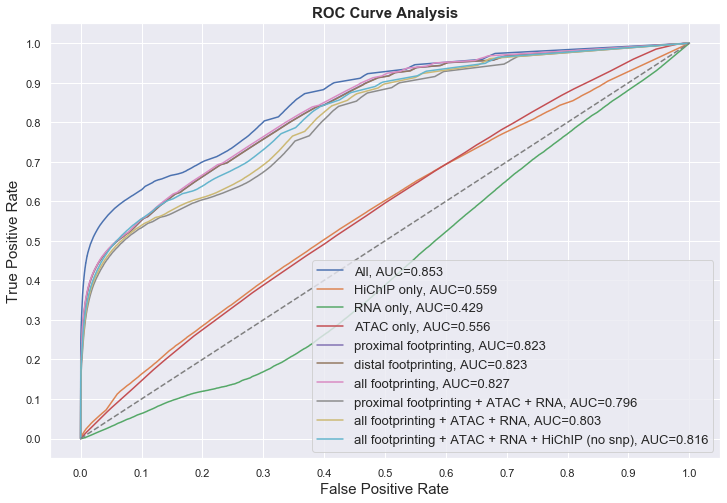

In [66]:
fig = plt.figure(figsize=(12,8))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='grey', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')
plt.savefig(os.path.join(save_dir, 'roc_diff_data.png'))
plt.show()


# 4 Clustering

Dimensionality reduction 

In [68]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap


In [69]:
data_all_norm_df = pd.DataFrame(data_all_norm, columns=data_all_varfilt_cols)

In [70]:
data_all_norm_df = pd.concat([data_all_norm_df, tissue_df['tissue'],pd.DataFrame(genes_all,columns=['gene'])],axis=1)


In [163]:
# data_all_norm_df.to_csv(os.path.join(save_dir, 'data_all_norm_df.csv'))

In [78]:
skin_gene_list = pd.read_csv('annon/skin_disease_genes.txt',sep='\t',header=None).loc[:,0]
skin_gene_list = list(skin_gene_list)

In [82]:
data_all_norm_df.gene.isin(select_gene_list)

0         False
1         False
2         False
3         False
4         False
          ...  
291001    False
291002    False
291003    False
291004    False
291005    False
Name: gene, Length: 291006, dtype: bool

In [81]:
select_gene_list = skin_gene_list
select_gene_idx = list(np.where([x in select_gene_list for x in genes_all][0]))
select_gene_idx

/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


[array([], dtype=int64)]

In [ ]:
# idx_choice = np.random.choice(data_all_norm_df.index.values, 10000)
idx_choice = 
data_all_norm_df_subset = data_all_norm_df.loc[idx_choice]

### 4A PCA

In [164]:
n_comp = 50
pca = PCA(n_components=n_comp)
pca_result = pca.fit_transform(data_all_norm_df[data_all_varfilt_cols].values)


In [165]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
sum(pca.explained_variance_ratio_)

Explained variation per principal component: [0.09269922 0.07568042 0.04283563 0.02975308 0.02862893 0.01522296
 0.01434135 0.01369804 0.01261554 0.01082941 0.0102124  0.00900246
 0.00806793 0.00764602 0.00721495 0.00698534 0.00676486 0.00647639
 0.00622574 0.00593968 0.00586809 0.00567268 0.00560928 0.00543636
 0.00535845 0.00529476 0.00521722 0.00513622 0.00504756 0.00493203
 0.00466049 0.00460817 0.00452245 0.00444506 0.00438199 0.00433111
 0.00423227 0.00420925 0.00408197 0.00404494 0.00391202 0.00371027
 0.00362439 0.00360608 0.00353727 0.00350256 0.00343258 0.00337189
 0.00326878 0.00325935]


0.5431558941109896

In [166]:
for i in range(n_comp):
    data_all_norm_df['pc_'+str(i+1)] = pca_result[:,i]


In [167]:
data_all_norm_df.columns

Index(['AHR_anc', 'AHR_loop', 'ALX1_anc', 'ALX1_loop', 'ARID5B_anc',
       'ARID5B_loop', 'ARNTL_anc', 'ARNTL_loop', 'ARNT_anc', 'ARNT_loop',
       ...
       'pc_41', 'pc_42', 'pc_43', 'pc_44', 'pc_45', 'pc_46', 'pc_47', 'pc_48',
       'pc_49', 'pc_50'],
      dtype='object', length=706)

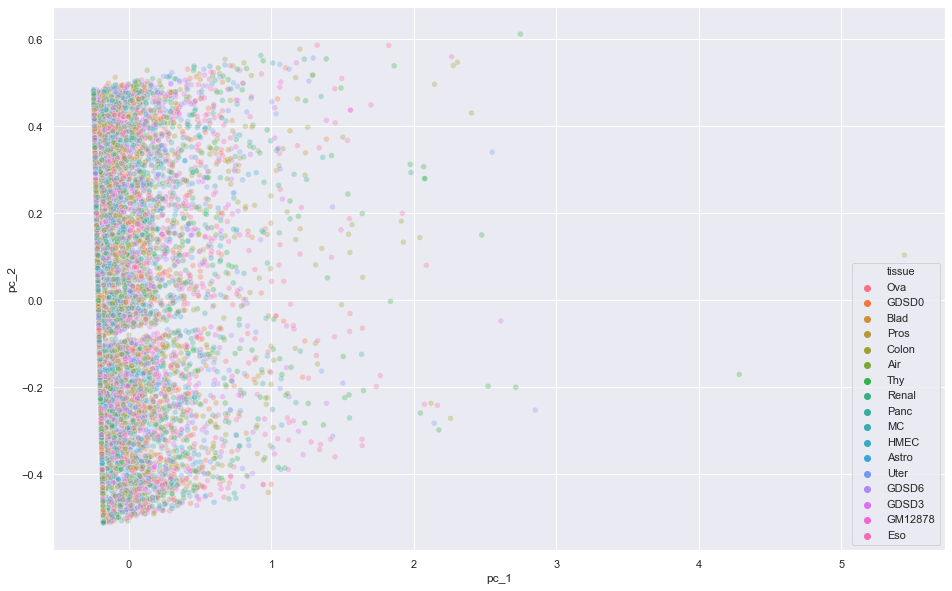

In [168]:
idx_choice = np.random.choice(data_all_norm_df.index.values, 10000)
plt.figure(figsize=(16,10))
sns.scatterplot(
    x='pc_1', y='pc_2',
    hue="tissue",
#     palette=sns.color_palette("hls", 10),
    data=data_all_norm_df.loc[idx_choice],#df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)
plt.savefig(os.path.join(save_dir, 'dimred_pca12.png'))

In [169]:
# figure out what's responsible for a pc space
pc2_df = pd.DataFrame({'features':data_all_varfilt_cols, 'pc_2_coeff':pca.components_[1]})#,orient='index')
pc2_df['pc_2_coeff_abs'] = abs(pc2_df['pc_2_coeff'])
pc2_df.sort_values('pc_2_coeff_abs',ascending=False)

,features,pc_2_coeff,pc_2_coeff_abs
653,gene_num,-9.971818e-01,9.971818e-01
435,SP1_loop,1.086943e-02,1.086943e-02
439,SP3_loop,1.034853e-02,1.034853e-02
531,ZBTB17_loop,1.008800e-02,1.008800e-02
223,KLF6_loop,9.917214e-03,9.917214e-03
...,...,...,...
360,POU3F2_anc,-2.449803e-06,2.449803e-06
431,SOX5_loop,2.158089e-06,2.158089e-06
270,MYB_anc,-9.147794e-07,9.147794e-07
103,ETV2_loop,-8.858045e-07,8.858045e-07


In [128]:
# idx_choice = np.random.choice(data_all_norm_df.index.values, 1000)

# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x='pc_1', y='pc_2',
#     hue="gene",
# #     palette=sns.color_palette("hls", 10),
#     data=data_all_norm_df.loc[idx_choice],#df.loc[rndperm,:],
#     legend="brief",
#     alpha=0.3
# )
# plt.savefig(os.path.join('networks/representations', 'dimred_pca12_gene.png'))

### 4B: tsne

In [170]:
idx_choice = np.random.choice(data_all_norm_df.index.values, 10000)
data_all_norm_df_subset = data_all_norm_df.loc[idx_choice]

In [171]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(pca_result[idx_choice,:])
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.024s...
[t-SNE] Computed neighbors for 10000 samples in 3.616s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.006422
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.778030
[t-SNE] KL divergence after 300 iterations: 2.607139
t-SNE done! Time elapsed:

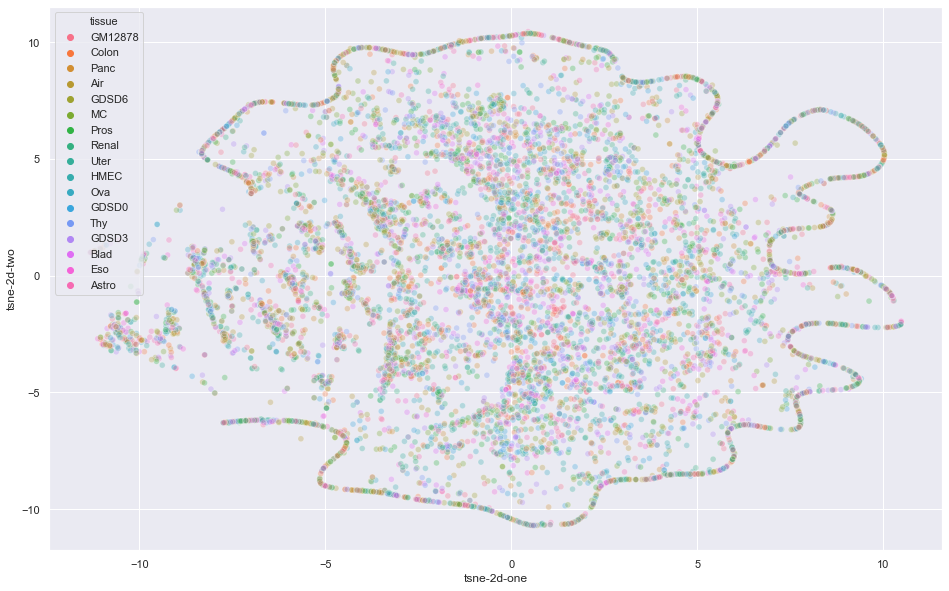

In [172]:
data_all_norm_df_subset['tsne-2d-one'] = tsne_results[:,0]
data_all_norm_df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="tissue",
#     palette=sns.color_palette("hls", 10),
    data=data_all_norm_df_subset,
    legend="full",
    alpha=0.3
)
plt.savefig(os.path.join(save_dir, 'dimred_tsne2.png'))

### 4C UMAP

In [173]:
%%time
reducer = umap.UMAP()
embedding = reducer.fit_transform(pca_result[idx_choice,:])
embedding.shape

/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../opt/anaconda3/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/Users/mguo123/opt/anaconda3/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../opt/anaconda3/lib/python3.7/site-packages/

CPU times: user 20.5 s, sys: 485 ms, total: 21 s
Wall time: 19 s


(10000, 2)

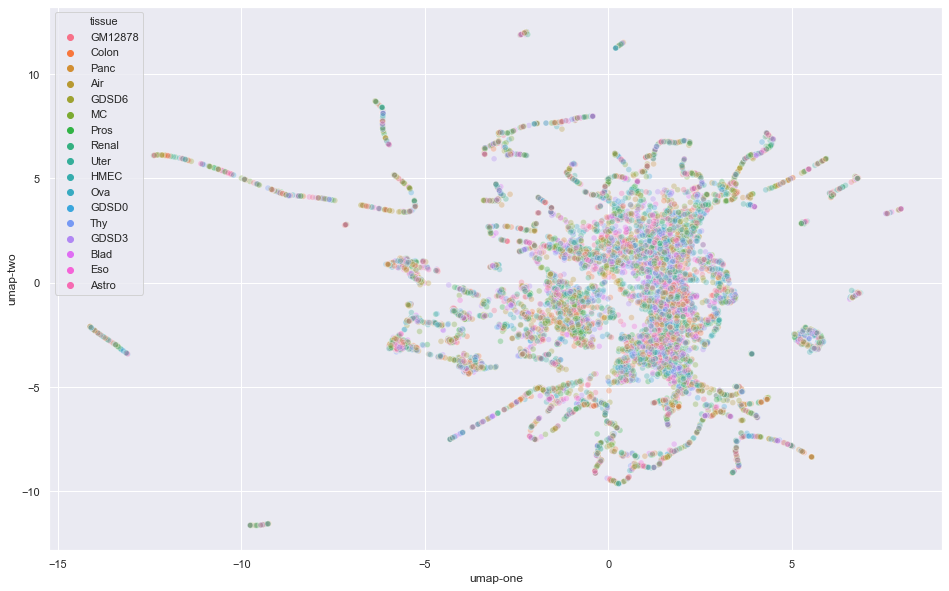

In [174]:
data_all_norm_df_subset['umap-one'] = embedding[:,0]
data_all_norm_df_subset['umap-two'] = embedding[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="umap-one", y="umap-two",
    hue="tissue",
#     palette=sns.color_palette("hls", 10),
    data=data_all_norm_df_subset,
    legend="full",
    alpha=0.3
)
plt.savefig(os.path.join(save_dir, 'dimred_umap.png'))

In [211]:
genes_all[labels_all_bin]

array([['A1BG'],
       ['A1CF'],
       ['A2M'],
       ...,
       ['ZYX'],
       ['ZZEF1'],
       ['ZZZ3']], dtype=object)

In [216]:
genes_all_count = Counter(list(genes_all[labels_all_bin]))

TypeError: unhashable type: 'numpy.ndarray'

In [243]:
gene_count = {}
for gene in genes_all[np.array(labels_all_bin)==1][:,0]:
    if gene in gene_count.keys():
        gene_count[gene]+=1
    else:
        gene_count[gene]=1

In [242]:
labels_all_bin==1

False

In [246]:
common_genes = []
for gene,count in gene_count.items():
     if count==17:
            common_genes.append(gene)
len(common_genes)

6341